<a href="https://colab.research.google.com/github/BryanMed/Sequences-Time-Series-and-Prediction/blob/master/Semana1SeriesTemporales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Semana 1, introducción a series temporales y algoritmos simples de forecasting.

Instalamos la versión de tensorflow, en este caso la versión beta 1 

In [0]:
pip install tensorflow==2.0.0b1

Agregamos las librerias necesarias, verificando la versión de tensorflow.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

2.0.0-beta1


El siguiente bloque de código permitirá crear las series temporales con seasonality, trend y noise.

In [0]:
def plot_series(time, series, format='-', start=0, end=None, title=None):
  """función para mostrar los gráficos""" 
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Tiempo')
  plt.ylabel('Valor')
  plt.title(title)
  plt.grid(True)

def trend(time, slope=0):
  """tendencia que se le añadirá a la serie temporal"""
  return slope*time

def seasonal_pattern(season_time):
  """patrón arbitraario"""
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi),
                  1/np.exp(3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
  """repite el mismo patrón en cada periodo"""
  season_time = ((time+phase) %period) / period
  return amplitude * seasonal_pattern(season_time) 

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

Creamos la serie temporal e iremos añadiendo la temporalidad, tendencia y ruido.

In [5]:
time = np.arange(4 * 365 + 1, dtype='float32') #serie correspondiente a 4 años
print(str(time.size) + "  " + str(time.dtype))


1461  float32


Visualizamos las funciones anteriores

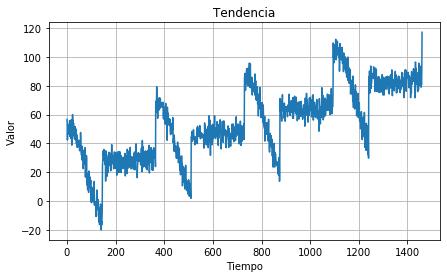

In [6]:
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

#creamos la serie temporal añadiendo linea de base, tendencia, estacionalidad
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

#también agregamos ruido
series += noise(time, noise_level, seed=10)

plt.figure(figsize=(7, 4))
plot_series(time, series, title='Tendencia')
plt.show()

Finalmente tenemos las series temporales, ahora dividiremos la serie en los distintos periodos (entrenamiento, validación y prueba).

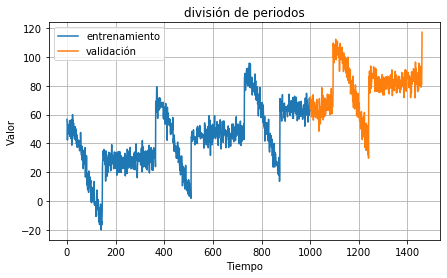

In [7]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(7, 4))
plot_series(time_train, x_train)
plot_series(time_valid, x_valid, title='división de periodos')
plt.legend(('entrenamiento', 'validación'))
plt.show()

# Naive Forecast

La manera en la que el naive forecast realiza la predicción es tomar el último valor y asumir que el siguiente valor será el mismo.

In [0]:
# el naive forecast asigna el valor pasado a la predicción actual
naive_forecast = series[split_time -1:-1]

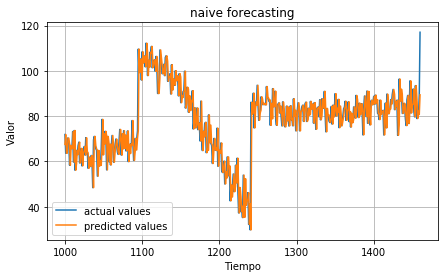

In [9]:
plt.figure(figsize=(7, 4))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast, title='naive forecasting')
plt.legend(('actual values', 'predicted values'))
plt.show()

Realicemos un "zoom" (básicamente tomamos pocas muestras de las series temporales para ver que onda.

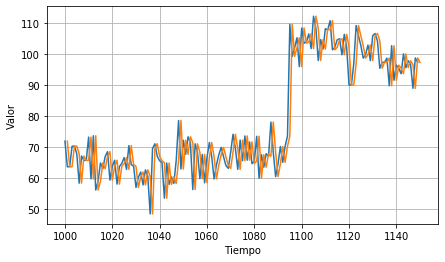

In [10]:
plt.figure(figsize=(7, 4))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

Podemos observar que el naive forecast tiene como lag 1 paso detrás de las series temporales.

Ahora calcularemos el error cuadrático medio (*mse*) y el error absoluto medio entre los valores predichos y los reales.

In [11]:
print("mse: " + str(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy()))
print("mae: " + str(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()))

mse: 61.56349
mae: 5.915332


Este es el algoritmo de forecast más chafón, pero servirá para comparar con otros algoritmos.

# Moving average forecast

In [0]:
def moving_average_forecast(series, window_size):
  """predecir la media de los últimos valores de la serie de acuerdo al
     tamaño de ventana.
     Si window_size=1, la predicción será equivalente al naive forecast"""
  forecast = [] 
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

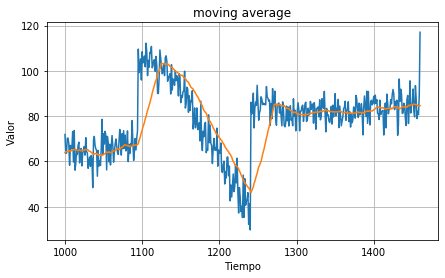

In [15]:
moving_avg = moving_average_forecast(series, 30)[split_time-30:]

plt.figure(figsize=(7, 4))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg, title='moving average')
plt.show()

In [16]:
print("mse : " + str(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy()))
print("mae : " + str(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()))

mse : 113.220634
mae : 7.326642


La predicción utilizando moving average es peor que utilizando un naive forecasting, esto es porque el moving average no anticipa la trend ni la seasonality, con lo cual removeremos estos factors utilizando *differencing*.
Dado que el periodo de seasonality es de 365 dias, vamos a restar el valor en el tiempo t-365 a partir del valor en el tiempo t.

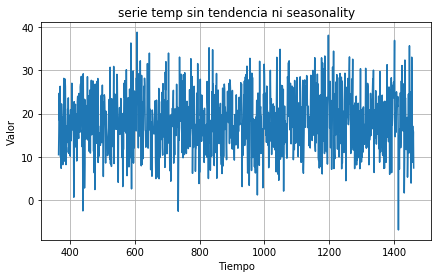

In [18]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(7,4))
plot_series(diff_time, diff_series, title='serie temp sin tendencia ni seasonality')
plt.show()

Ahora que nuestra serie temporal no tiene trend ni seasonality, utilizaremos el moving average

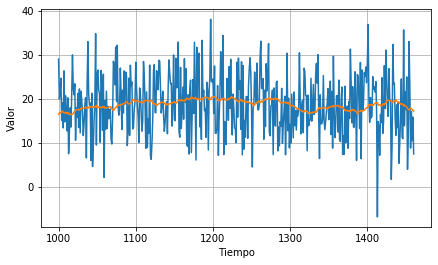

In [19]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(7,4))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

Bien, esta vez agregaremos la trend y la seasonality al agregar los valores pasados de t - 365:

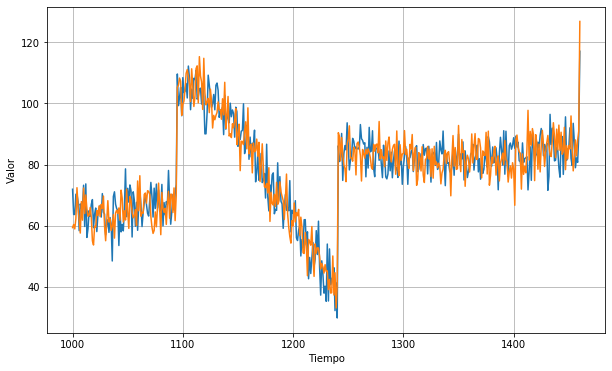

In [22]:
diff_moving_avg_plus_past = series[split_time - 365: -365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [23]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

49.29957
5.732639
